In [1]:
from pydub import AudioSegment
import os

# audio_path = "audio/"
# for i in os.listdir(audio_path):
#     if i.endswith(".wav"):
#         sound = AudioSegment.from_wav(audio_path + i)
#         sound = sound.set_channels(1)
#         sound.export(audio_path + i, format="wav")
#         print(i)

ImportError: No module named pydub

In [1]:
import numpy as np
import os

label_path = "../mydataset/annotation2/"

audio = []
tab = []

for i in os.listdir(label_path):
    if i.endswith(".npz"):
        data = np.load(label_path + i, allow_pickle=True)
        audio.append(len(data["audio"]))
        tab.append(len(data["tab"]))
        print(i, data.files, data["audio"].shape, data["tab"].shape)
        print(data["tab"])
        break


track1.npz ['audio', 'tab'] (8192, 192) (1024,)
[3021 3004 3010 ...    0    0    0]


In [11]:
from getdataset import Mydataset
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import torch.optim as optim
# from pytorch_memlab import profile
    
BATCH_NUM = 3
EPOCH_NUM = 1

all_losses = []
print("training ...")
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 7, (3, 1))
        self.conv2 = nn.Conv2d(16, 16, 7, (3, 1))
        self.conv3 = nn.Conv2d(16, 32, 7, (3, 1))
        self.conv4 = nn.Conv2d(32, 32, 5, 2)
        self.conv5 = nn.Conv2d(32, 32, 5, 2)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        
        self.fc = nn.Linear(640, 120)
        
    # @profile

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.relu(self.conv2(x))
        x = f.relu(self.conv3(x))
        x = f.relu(self.conv4(x))
        x = f.relu(self.conv5(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = self.drop2(x)
        x = x.permute(0, 2, 1, 3)
        x = x.reshape(x.shape[0], -1, x.shape[2]*x.shape[3])
        x = self.fc(x)
        x = x.permute(2, 0, 1)
        x = x.contiguous()
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=120, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 4096)
        self.fc2 = nn.Linear(4096, vocab_size)
        self.flatten = nn.Flatten()

    def forward(self, sequence, x):
        embedding = self.embeddings(sequence)
        x, state = self.rnn(embedding, x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x, state

embedding_dim = 100
hidden_dim = 36
vocab_size = 3024

#set gpu
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim).to(device)

#loss
criterion = nn.CrossEntropyLoss(ignore_index=0)

#optimizer
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

#make dataloader
dataset = Mydataset()

train_dataset = Subset(dataset, list(range(16)))
validation_dataset = Subset(dataset, list(range(16,19)))

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size=BATCH_NUM
    )
validation_dataloader = DataLoader(
    dataset = validation_dataset,
    batch_size=BATCH_NUM
    )

#train
for epoch in range(EPOCH_NUM):
    epoch_loss = 0

    for data, label in train_dataloader:
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        input_tensor = torch.tensor(data, dtype=torch.float32, device=device)
        output_tensor = torch.tensor(label, dtype=torch.int64, device=device)
        
        encoder_state = encoder(input_tensor)
        
        source = output_tensor[:, :-1]
        target = output_tensor[:, 1:]
        print(output_tensor.shape)
        print(output_tensor)
        print(source.shape)
        print(source)
        print(target.shape)
        print(target)
        break
        
        loss = 0
        
        decoder_output, _ = decoder(source, encoder_state)
        
        for j in range(decoder_output.size()[1]):
            #to avoid when target is [0, 0, 0]
            if torch.equal(target[:, j] ,torch.zeros(len(target[:, j]), dtype=torch.int64, device=device)):
                continue
            
            loss += criterion(decoder_output[:, j, :], target[:, j])
            
            
        epoch_loss += loss.item()
        
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
# print("Done")

training ...
torch.Size([3, 1024])
tensor([[3021, 3004, 3010,  ...,    0,    0,    0],
        [3021,  933,  958,  ...,    0,    0,    0],
        [3021, 3004, 3007,  ...,    0,    0,    0]], device='cuda:1')
torch.Size([3, 1023])
tensor([[3021, 3004, 3010,  ...,    0,    0,    0],
        [3021,  933,  958,  ...,    0,    0,    0],
        [3021, 3004, 3007,  ...,    0,    0,    0]], device='cuda:1')
torch.Size([3, 1023])
tensor([[3004, 3010, 1901,  ...,    0,    0,    0],
        [ 933,  958,  958,  ...,    0,    0,    0],
        [3004, 3007,  953,  ...,    0,    0,    0]], device='cuda:1')
Epoch 0: 0.00


/tmp/ipykernel_4813/3517911129.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(data, dtype=torch.float32, device=device)
/tmp/ipykernel_4813/3517911129.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor = torch.tensor(label, dtype=torch.int64, device=device)


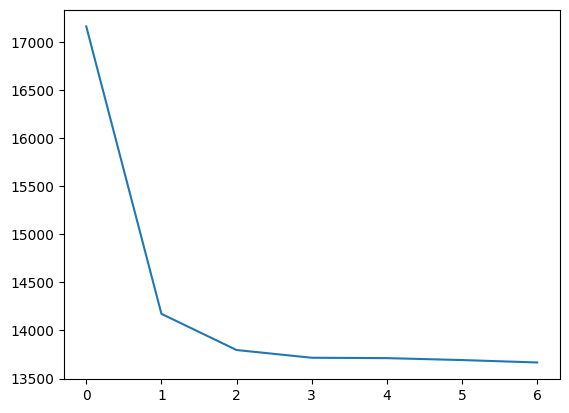

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_losses)

In [7]:
import pandas as pd

def get_max_index(decoder_output):
  results = []
  for h in decoder_output:
    results.append(torch.argmax(h))
  return torch.tensor(results, device=device).view(3, 1)

def evaluation(predicts, labels):
  results = []
  number_of_match = 0
  for i, (predict, label) in enumerate(zip(predicts, labels)):
    result = {}
    if predict == label and predict != 0:
      number_of_match += 1
      result["result"] = "0"
    else:
      result["result"] = "1"
    result["id"] = i
    result["label"] = label
    result["predict"] = predict
    results.append(result)
  accuracy = number_of_match/len(labels)
  return accuracy, results

predicts = []
row = []
for i, (data, label) in enumerate(validation_dataloader):
  with torch.no_grad():
    input_tensor = torch.tensor(data, dtype=torch.float32, device=device)
    label_tensor = torch.tensor(label, dtype=torch.int64, device=device)
    encoder_state = encoder(input_tensor)
    
    start_id_batch = [[3021] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_id_batch, device=device)
    
    decoder_hidden = encoder_state
    batch_tmp = torch.zeros(BATCH_NUM, 1, device=device)
    
    for _ in range(label.shape[1]):
      decoder_output, decoder_hidden = decoder(decoder_input_tensor, decoder_hidden)
      
      decoder_input_tensor = get_max_index(decoder_output.squeeze())
      
      decoder_next_input = []
      for batch_out in decoder_input_tensor:
        if batch_out == 3022 or batch_out == 3023:
          decoder_next_input.append(3023)
        else:
          decoder_next_input.append(batch_out)
          
      decoder_input_tensor = torch.tensor([[j] for j in decoder_next_input], device=device)
      
      batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)
      
    predicts.append(batch_tmp[:,1:])
    
    batch_output = label_tensor
    batch_predict = predicts[i]
    for output, predict in zip(batch_output, batch_predict):
      accuracy, results = evaluation(predict.to('cpu').numpy().copy(), output.to('cpu').numpy().copy())
      print(accuracy)
      for j in results:
        print(j)
      break
    

/tmp/ipykernel_4813/3054727120.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(data, dtype=torch.float32, device=device)
/tmp/ipykernel_4813/3054727120.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label, dtype=torch.int64, device=device)


0.0
{'result': '1', 'id': 0, 'label': 3021, 'predict': 2124.0}
{'result': '1', 'id': 1, 'label': 1426, 'predict': 2124.0}
{'result': '1', 'id': 2, 'label': 1403, 'predict': 2124.0}
{'result': '1', 'id': 3, 'label': 156, 'predict': 2124.0}
{'result': '1', 'id': 4, 'label': 179, 'predict': 2124.0}
{'result': '1', 'id': 5, 'label': 1479, 'predict': 2124.0}
{'result': '1', 'id': 6, 'label': 1401, 'predict': 2124.0}
{'result': '1', 'id': 7, 'label': 1378, 'predict': 2124.0}
{'result': '1', 'id': 8, 'label': 1379, 'predict': 2124.0}
{'result': '1', 'id': 9, 'label': 479, 'predict': 2124.0}
{'result': '1', 'id': 10, 'label': 1426, 'predict': 2124.0}
{'result': '1', 'id': 11, 'label': 1403, 'predict': 2124.0}
{'result': '1', 'id': 12, 'label': 156, 'predict': 2124.0}
{'result': '1', 'id': 13, 'label': 179, 'predict': 2124.0}
{'result': '1', 'id': 14, 'label': 1479, 'predict': 2124.0}
{'result': '1', 'id': 15, 'label': 1426, 'predict': 2124.0}
{'result': '1', 'id': 16, 'label': 1401, 'predict':

In [43]:
import collections

labels = []
for data, label in train_dataloader:
    for i in label:
        a = i.to("cpu").detach().numpy().copy()
        for j in a:
            labels.append(j)
c = collections.Counter(labels)
for k, count in c.most_common(20):
    print("Id ", k, ":", count, " times")

Id  0 : 10306  times
Id  1451 : 168  times
Id  953 : 120  times
Id  1403 : 117  times
Id  1476 : 106  times
Id  1351 : 99  times
Id  1001 : 99  times
Id  1876 : 98  times
Id  1376 : 95  times
Id  1381 : 86  times
Id  1426 : 84  times
Id  1405 : 82  times
Id  1428 : 81  times
Id  1401 : 78  times
Id  1408 : 71  times
Id  1433 : 70  times
Id  1383 : 70  times
Id  1851 : 63  times
Id  929 : 63  times
Id  1406 : 59  times
